**Importing all the neccessary libraries to process model building**

In [10]:
import pandas as pd
import numpy as np
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
import os
import glob
!pip install seed
from numpy.random import seed
seed(1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Function used to read the caption feature**

In [11]:
def caption_read(fname):
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

**Function used to read the C3D feature**

In [12]:
def read_C3D(fname):
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()]
    return C3D

**Function to calculate Spearmann's Correlation Coefficient**

In [13]:
def Get_score(Y_pred,Y_true):
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

**Reading the caption feature using caption_read function, Loading the prediction labels (memorability score) in pandas dataframe, Also reading the C3D feature files**

In [14]:
caption_file_train = 'Captions/Train/dev-set_video-captions.txt'
caption_file_test = 'Captions/Test/test-set-1_video-captions.txt'

labels_test = pd.read_csv('Ground_truth/Test/ground_truth_template.csv')
labels = pd.read_csv('Ground_truth/Train/ground-truth.csv')

C3D_train = 'C3D/Train/'
C3D_test = 'C3D/test'

In [15]:
cap_train = caption_read(caption_file_train)
cap_test = caption_read(caption_file_test)

**Lets look at the caption trainset features**

In [16]:
cap_train.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


**Now, Removing the Punctuation marks and making it lower case for the Caption feature (train and test)**

In [17]:
def Punctuation(cap_train): 
  for i, x in enumerate (cap_train['caption']):
      text = ''.join([c if c not in punctuation else ' ' for c in x]).lower()
      cap_train.loc[i,'caption'] = text 

Punctuation(cap_train)
Punctuation(cap_test) 

**Inorder to have a cleaned and preprocessed caption text files we are going to remove the irrelavant words called stop words and we are also making it lemmatized. Lemmatization makes the words to its root form using Wordnet corpus**

In [18]:
stop_words = set(stopwords.words('english')) 
cap_train['caption'] = cap_train['caption'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
cap_test['caption'] = cap_test['caption'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [19]:
lemmatizer = WordNetLemmatizer()
cap_train['caption'] = cap_train['caption'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))
cap_test['caption'] = cap_test['caption'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, 'v') for word in x.split()]))

**Now, Let us have a look at the cleaned caption feature for training and testing**

In [20]:
cap_train.head()

,video,caption
0,video3.webm,blonde woman massage tilt
1,video4.webm,roulette table spin ball closeup shoot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hover airport
4,video10.webm,couple relax picnic crane shoot


In [21]:
cap_test.head()

,video,caption
0,video7494.webm,green jeep struggle drive huge rock
1,video7495.webm,hike woman tourist walk forward mountains suns...
2,video7496.webm,close african american doctor hand use sphygmo...
3,video7497.webm,slow motion man use treadmill gym regular phys...
4,video7498.webm,slow motion photographer national park


**Let us have a look at the ground truth values of short term and long term memorability score**

In [22]:
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


**Merging the Captions with the video names and memorability scores**

In [23]:
cap_train = pd.merge(cap_train,
                 labels[['video', 'short-term_memorability', 'long-term_memorability']],
                 on='video')
cap_train.head()

,video,caption,short-term_memorability,long-term_memorability
0,video3.webm,blonde woman massage tilt,0.924,0.846
1,video4.webm,roulette table spin ball closeup shoot,0.923,0.667
2,video6.webm,khr gangsters,0.863,0.700
3,video8.webm,medical helicopter hover airport,0.922,0.818
4,video10.webm,couple relax picnic crane shoot,0.950,0.900


In [24]:
print('Ground truth video memorability prediction file on train',labels.shape)
print('Ground truth video memorability prediction file on test',labels_test.shape)
print('Caption feature file on train', cap_train.shape)
print('Caption feature file on test', cap_test.shape)

Ground truth video memorability prediction file on train (6000, 5)
Ground truth video memorability prediction file on test (2000, 5)
Caption feature file on train (6000, 4)
Caption feature file on test (2000, 2)


**I am using TFIDF vectorizer to convert the collection of raw caption features into a matrix of TFIDF features. Here I am passing use_idf = True because I want to assign low weights to the words that occur very frequently and scale up the weights for rare words.**

**I am also passing smooth_idf = True because if a word which is not fitted to the train data but occurs in the test dataset, smooth_idf allows to successfully process it.**

**max_features is used to retrieve the top 3000 tfidf feature vectors for capturing better contextual information**

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_trainset = TfidfVectorizer(use_idf = True, smooth_idf = True, max_features = 3000)

In [26]:
X_trainset = vectorizer_trainset.fit_transform(cap_train['caption'])
X_testset =vectorizer_trainset.transform(cap_test['caption'])

In [27]:
feature_names = vectorizer_trainset.get_feature_names()
X_trainset = X_trainset.toarray() # Train Caption features converted to an array
X_testset = X_testset.toarray() # Test caption features converted to an array
print('Caption features of training datset', X_trainset.shape)
print('Caption features of testing dataset', X_testset.shape)

Caption features of training datset (6000, 3000)
Caption features of testing dataset (2000, 3000)


**Now our development vocabulary size and testing vocabulary size is 3000**

In [28]:
Caption_features = pd.DataFrame(X_trainset, columns=feature_names)
Caption_features.tail()

,ab,accident,accidently,across,active,activity,actor,acupuncture,add,addict,...,yukon,zealand,zebra,zebras,zero,zip,zipper,zone,zoo,zoom
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Loading the C3D features with their respective video file names (Training set)**

In [29]:
list_c3d = [] 
list_video = [] 
path = 'C3D/Train/*.txt'
for filename in glob.glob('C3D/Train/*.txt'):
    s= read_C3D(filename)
    list_c3d.append(s)
    list_video.append(((filename.split('/')[-1]).split('.')[0])+ '.webm') 

In [30]:
print('Number of C3D features are', len(list_c3d[0]))
print('Training data of C3D features', len(list_video))

Number of C3D features are 101
Training data of C3D features 6000


**Making a array dataframe of C3D features where the list_c3d is the list of the 101 C3D dimensions and list_video is a list for the 6000 training video records**

In [31]:
c3d_feature = pd.DataFrame(np.array(list_c3d).reshape(6000,101))
c3d_feature["video"] = list_video
c3d_feature.tail()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,video
5995,0.000213,0.001159,0.008674,0.000032,0.000030,0.000026,0.000060,2.684500e-04,0.000036,0.000011,...,1.898800e-04,0.000109,0.000135,0.000174,1.320000e-05,0.006762,0.000008,0.002438,0.004736,video2881.webm
5996,0.001955,0.003218,0.000135,0.000041,0.000002,0.000019,0.000135,2.454000e-05,0.000051,0.000412,...,3.770000e-06,0.000001,0.020093,0.000029,7.600000e-07,0.000060,0.014110,0.002027,0.020071,video1136.webm
5997,0.043981,0.000058,0.000507,0.000006,0.000005,0.000004,0.000042,3.000000e-07,0.000032,0.001402,...,5.400000e-07,0.000001,0.000611,0.000007,1.030000e-06,0.000002,0.000460,0.000088,0.000872,video6105.webm
5998,0.007485,0.021147,0.013090,0.000002,0.000002,0.000003,0.000228,3.873000e-05,0.000006,0.000023,...,7.860000e-06,0.000027,0.000170,0.000004,1.600000e-07,0.000493,0.000299,0.000257,0.001004,video827.webm
5999,0.005055,0.000065,0.001686,0.000152,0.000002,0.000067,0.000002,2.330000e-05,0.000058,0.000283,...,1.140000e-06,0.000009,0.003081,0.000014,7.920000e-06,0.000023,0.000003,0.000016,0.007559,video6830.webm


**Loading the C3D features for the testing set with their video file names**

In [32]:
list_c3d_test = [] 
list_video_test = [] 
path = 'C3D/test/*.txt'
for filename in glob.glob('C3D/test/*.txt'):
    s= read_C3D(filename)
    list_c3d_test.append(s)
    list_video_test.append(((filename.split('/')[-1]).split('.')[0])+ '.webm') 

In [33]:
print('Number of C3D features for testing set', len(list_c3d_test[0]))
print('Training data of C3D features for testing set', len(list_video_test))

Number of C3D features for testing set 101
Training data of C3D features for testing set 2000


In [34]:
c3d_feat_testset = pd.DataFrame(np.array(list_c3d_test).reshape(2000,101))
c3d_feat_testset["video"] = list_video_test
c3d_feat_testset.tail()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,video
1995,0.070512,0.308193,0.001473,3.556400e-04,1.748000e-05,4.778000e-05,0.000100,1.751530e-03,0.009924,0.000032,...,7.841000e-05,4.164000e-05,0.002845,1.544700e-04,3.843000e-05,0.000222,0.000528,0.007921,0.029476,video9699.webm
1996,0.000177,0.000232,0.065861,6.900000e-07,4.749000e-05,1.830400e-04,0.000041,1.570700e-04,0.000009,0.000126,...,3.870000e-06,3.497900e-04,0.000053,1.268500e-04,3.530000e-06,0.000286,0.000018,0.000037,0.157573,video9961.webm
1997,0.116897,0.004120,0.000082,1.384000e-05,1.500000e-07,1.600000e-07,0.000039,5.500000e-07,0.000003,0.000002,...,9.900000e-07,7.000000e-08,0.000804,6.600000e-07,6.000000e-08,0.000003,0.001728,0.003949,0.000078,video9826.webm
1998,0.209553,0.125281,0.001236,6.160000e-05,4.180000e-06,3.363000e-05,0.000406,1.374800e-04,0.000040,0.000477,...,1.135000e-05,2.204000e-05,0.007644,1.904700e-04,6.680000e-06,0.000031,0.013981,0.019693,0.000028,video8004.webm
1999,0.000354,0.001859,0.007415,2.181700e-04,2.167272e-02,9.846000e-05,0.000048,6.119900e-04,0.000267,0.001371,...,1.317019e-02,2.874388e-02,0.014465,7.320400e-04,1.390000e-06,0.009986,0.000233,0.008096,0.002037,video9295.webm


**Let us proceed with training and testing the caption features alone with various machine algorithms**

In [35]:
X_devset = X_trainset # input features used for training
X_testset = X_testset # input features used for testing
Y = cap_train[['short-term_memorability','long-term_memorability']].values

**Splitting the 6000 training dataset into train and test to get the spearman's correlation score, This helps to identify the best fit algorithm**

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
                                             X_devset, Y, 
                                             test_size=0.33, 
                                             random_state=42)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4020, 3000)
X_test (1980, 3000)
Y_train (4020, 2)
Y_test (1980, 2)


**Using Linear regression algorithm in captions to predict the short term and long term memorability score**

In [37]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression(normalize = False, copy_X = True)
LR_model.fit(X_train, Y_train)
y_pred = LR_model.predict(X_test)
Get_score(y_pred, Y_test)

The Spearman's correlation coefficient is: 0.142
The Spearman's correlation coefficient is: 0.080


**Using Decision Tree Regression model in captions to predict the short term and long term memorability scores**

In [38]:
from sklearn.tree import DecisionTreeRegressor
DT_model = DecisionTreeRegressor(criterion = 'mse', splitter = 'random', random_state = 0)
DT_model.fit(X_train, Y_train)
y_pred = DT_model.predict(X_test)
Get_score(y_pred, Y_test)

The Spearman's correlation coefficient is: 0.300
The Spearman's correlation coefficient is: 0.110


**Using K-Nearest Neighbors Regression model in captions to predict the short and long term memorability score**

In [39]:
from sklearn.neighbors import KNeighborsRegressor
KN_model = KNeighborsRegressor(n_neighbors=15, weights = 'uniform')
KN_model.fit(X_train,Y_train)
y_pred = KN_model.predict(X_test)
Get_score(y_pred, Y_test)

The Spearman's correlation coefficient is: 0.417
The Spearman's correlation coefficient is: 0.158


**Using Random forest regression algorithm model in captions to predict the short term and long term memorability score**

In [40]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor(n_estimators = 100, verbose = 2)
RF_model.fit(X_train, Y_train)
y_pred = RF_model.predict(X_test)
Get_score(y_pred, Y_test)

building tree 1 of 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


**From the above trained ML algorithms on titles of video files named  as Video captions with TFIDF we can conclude that K-Nearest Neighbour regression performed well with 0.417 score on short term memorability and Random forest regression performed better with 0.168 score for long-term memorability**

**Now let us investigate and build ML models on C3D feature alone**

**Merging the C3D feature with ground truth values**

In [41]:
c3d_feature = pd.merge(labels, c3d_feature, on='video')
c3d_feature.head() # C3D training dataset

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,0,1,2,3,4,...,91,92,93,94,95,96,97,98,99,100
0,video3.webm,0.924,34,0.846,13,0.020249,0.001578,0.000826,0.000945,0.000063,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,video4.webm,0.923,33,0.667,12,0.000118,0.000891,0.000188,0.000045,0.000063,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,video6.webm,0.863,33,0.700,10,0.011765,0.000746,0.000784,0.000013,0.000007,...,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,video8.webm,0.922,33,0.818,11,0.000223,0.000165,0.000007,0.000016,0.000005,...,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,video10.webm,0.950,34,0.900,10,0.000090,0.000615,0.003436,0.001281,0.003551,...,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323


In [42]:
c3d_trainset = c3d_feature.iloc[:,5:107].values
c3d_testset = c3d_feat_testset.iloc[:,:101]
print('Training set of C3D features', c3d_trainset.shape)
print('Testing set of C3D feature', c3d_testset.shape)

Training set of C3D features (6000, 101)
Testing set of C3D feature (2000, 101)


In [43]:
X = c3d_trainset # C3D input features for training
Y = labels[['short-term_memorability','long-term_memorability']].values

**Splitting the training set C3D features into Train and Test set for validation purposes**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', y_train.shape)
print('Y_test', y_test.shape)

X_train (4020, 101)
X_test (1980, 101)
Y_train (4020, 2)
Y_test (1980, 2)


**Using Linear regression algorithm on C3D features alone**

In [45]:
LR_model = LinearRegression(normalize = True, copy_X = True)
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.278
The Spearman's correlation coefficient is: 0.119


**Using Decision Tree regression algorithm on C3D features**

In [46]:
DT_model = DecisionTreeRegressor(criterion = 'friedman_mse', splitter = 'random', random_state = 0)
DT_model.fit(X_train, y_train)
y_pred = DT_model.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.117
The Spearman's correlation coefficient is: 0.055


**Using K-Nearest Neighbour Regression on C3D features**

In [47]:
KN_model = KNeighborsRegressor(n_neighbors=20, weights = 'distance')
KN_model.fit(X_train,y_train)
y_pred = KN_model.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.220
The Spearman's correlation coefficient is: 0.063


**Using Random forest regression on C3D features**

In [48]:
RF_model = RandomForestRegressor(n_estimators=500, random_state = 42, max_depth = 20)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
Get_score(y_pred, y_test)

The Spearman's correlation coefficient is: 0.327
The Spearman's correlation coefficient is: 0.151


**From the above trained ML algorithms on C3D features we can conclude that Random forest regression performed better with 0.327 score for short-term memorability and 0.151 for long-term memorability score**

**Now we are combining both the C3D feature and Video captions together using concatenate method for efficient model building (for both training and testing)**

In [49]:
Cap_C3D = np.concatenate((Caption_features, c3d_trainset), axis=1)
print('Training data with both Captions and C3D combined', Cap_C3D.shape)

Training data with both Captions and C3D combined (6000, 3101)


In [50]:
Cap_C3D_testset = np.concatenate((X_testset, c3d_testset), axis=1)
print('Testing data for captions and C3D features', Cap_C3D_testset.shape)

Testing data for captions and C3D features (2000, 3101)


In [ ]:
X = Cap_C3D # Training feature of 6000 videos both Caption and C3D
Y = labels[['short-term_memorability','long-term_memorability']].values

**Splitting the training dataset into train and test for validation purpose. You get 3101 features when you combine 3000 features from caption and 101 from C3D**

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                             X, Y, 
                                             test_size=0.33, 
                                             random_state=42)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4020, 3101)
X_test (1980, 3101)
Y_train (4020, 2)
Y_test (1980, 2)


**Using K-Nearest Neighbour Regression Algorithm for combining the two features Caption and C3D. Evaluate the performance using spearman's correlation coefficient**

**In order to find the number of neigbors for KNN regression, I am visualizing by giving a range from 20 to 30**

In [57]:
#arrays to store the training and testing accuracies
from sklearn.metrics import r2_score
neighbors = np.arange(20, 30)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, Y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, Y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Text(0, 0.5, 'Accuracy')

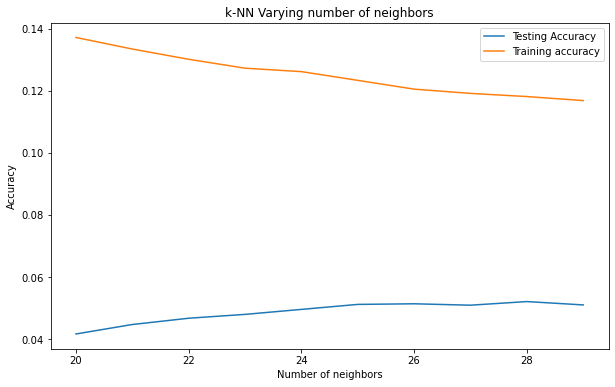

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
#plt.show()

**From the above plot, we can say that n_neighbors = 26 has the correct amount of training accuracy and testing accuracy. Thus the model DOES NOT OVERFIT**

In [68]:
KN_model = KNeighborsRegressor(n_neighbors=26, weights = 'distance')
KN_model.fit(X_train,Y_train)
y_pred = KN_model.predict(X_test)
Get_score(y_pred, Y_test)

The Spearman's correlation coefficient is: 0.381
The Spearman's correlation coefficient is: 0.169


**Now, we have to use the Whole training dataset of 6000 videos to train and fit in the KNN algorithm**

In [69]:
knn = KNeighborsRegressor(n_neighbors=26, weights = 'distance')
knn.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                    weights='distance')

In [70]:
y_pred = knn.predict(Cap_C3D_testset)
print(y_pred)

[[0.79242493 0.73804789]
 [0.82080719 0.78334419]
 [0.88481095 0.78188971]
 ...
 [0.87185275 0.77401673]
 [0.8695209  0.83346625]
 [0.87291473 0.74032822]]


**Creating a pandas dataframe for the output result predictions**

In [77]:
!pip install natsort
from natsort import natsorted
predictions = pd.DataFrame({'video': natsorted(labels_test['video']),
                    'short-term_memorability': [row[0] for row in y_pred],
                    'long-term_memorability':[row[1] for row in y_pred]
                        })

In [82]:
print(predictions.describe())

              video  short-term_memorability  long-term_memorability
count   2000.000000              2000.000000             2000.000000
mean    8760.857500                 0.854712                0.772196
std      730.600388                 0.030196                0.036600
min     7494.000000                 0.717023                0.625211
25%     8125.500000                 0.837484                0.748247
50%     8769.000000                 0.859253                0.774683
75%     9399.250000                 0.876557                0.797506
max    10008.000000                 0.931045                0.871264


**From the describe method of univariate analysis, we can see that a mean value of 0.85 is the probability of remembering the videos for a short-term and 0.77 is the probability of remembering the videos for a long-term one**

In [81]:
print(predictions.head())

   video  short-term_memorability  long-term_memorability
0   7494                 0.792425                0.738048
1   7495                 0.820807                0.783344
2   7496                 0.884811                0.781890
3   7497                 0.881872                0.823072
4   7498                 0.841656                0.784161


In [83]:
predictions.to_csv('Rebekah_Manimaran_19210518_predictions.csv')